In [92]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [93]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.dates as mdates 

# Reflect Tables into SQLAlchemy ORM

In [94]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [95]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [96]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)
# reflect the tables
Measurement = Base.classes.measurement
Station = Base.classes.station

C:\Users\eddy2\AppData\Local\Temp\ipykernel_15216\3113235674.py:3: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [97]:
# View all of the classes that automap found
print(Base.classes.keys())

['station', 'measurement']


In [98]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [99]:
# Create our session (link) from Python to the DB
session = Session(engine)


In [100]:
# Confirm session is active
print("Session created successfully!")

Session created successfully!


# Exploratory Precipitation Analysis

In [101]:
# Find the most recent date in the data set.
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
latest_date = dt.datetime.strptime(latest_date, "%Y-%m-%d")


# Print the result
print(f"The most recent date in the dataset is: {latest_date.date()}")

The most recent date in the dataset is: 2017-08-23


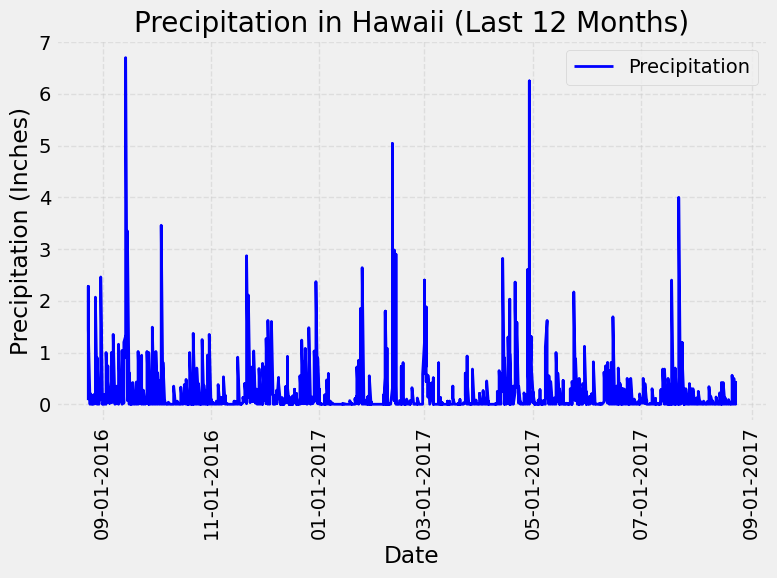

In [102]:
# Calculate the date one year from the most recent data point
one_year_ago = latest_date - dt.timedelta(days=365)

# Perform the query to retrieve precipitation data for the last 12 months
precip_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

# Convert the query results into a Pandas DataFrame
precip_df = pd.DataFrame(precip_data, columns=["date", "precipitation"])

# Drop rows with null values
precip_df.dropna(inplace=True)

# Convert the date column to datetime type
precip_df["date"] = pd.to_datetime(precip_df["date"])

# Set the date column as the index
precip_df.set_index("date", inplace=True)

# Sort the DataFrame by date
precip_df.sort_index(inplace=True)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(precip_df.index, precip_df["precipitation"], label="Precipitation", linewidth=2, color="blue")

# Format x-axis to show only **5** dates in MM-DD-YYYY format
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%Y'))  # Change format to MM-DD-YYYY


# Rotate the labels **vertically**
plt.xticks(rotation=90)

# Formatting the plot
plt.xlabel("Date")
plt.ylabel("Precipitation (Inches)")
plt.title("Precipitation in Hawaii (Last 12 Months)")
plt.legend()

# Improved grid for better readability
plt.grid(alpha=0.5, linestyle="--")

# Adjust layout to prevent overlapping labels
plt.tight_layout()

# Show the plot
plt.show()

In [103]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_summary = precip_df.describe()
print(precip_summary)

       precipitation
count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000


# Exploratory Station Analysis

In [104]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(Station.station).count()
print(f"Total number of stations: {total_stations}")

Total number of stations: 9


In [105]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

# Display the results
print("Most Active Stations (Ordered by Observations):")
for station, count in active_stations:
    print(f"Station ID: {station}, Observation Count: {count}")

Most Active Stations (Ordered by Observations):
Station ID: USC00519281, Observation Count: 2772
Station ID: USC00519397, Observation Count: 2724
Station ID: USC00513117, Observation Count: 2709
Station ID: USC00519523, Observation Count: 2669
Station ID: USC00516128, Observation Count: 2612
Station ID: USC00514830, Observation Count: 2202
Station ID: USC00511918, Observation Count: 1979
Station ID: USC00517948, Observation Count: 1372
Station ID: USC00518838, Observation Count: 511


In [106]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]  # First station in the sorted list

# Query to calculate min, max, and average temperature for the most active station
temp_stats = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
).filter(Measurement.station == most_active_station).all()

# Extract results
lowest_temp = temp_stats[0][0]
highest_temp = temp_stats[0][1]
average_temp = temp_stats[0][2]

# Display results
print(f"Temperature Statistics for Station {most_active_station}:")
print(f"Lowest Temperature: {lowest_temp}°F")
print(f"Highest Temperature: {highest_temp}°F")
print(f"Average Temperature: {average_temp:.2f}°F")


Temperature Statistics for Station USC00519281:
Lowest Temperature: 54.0°F
Highest Temperature: 85.0°F
Average Temperature: 71.66°F


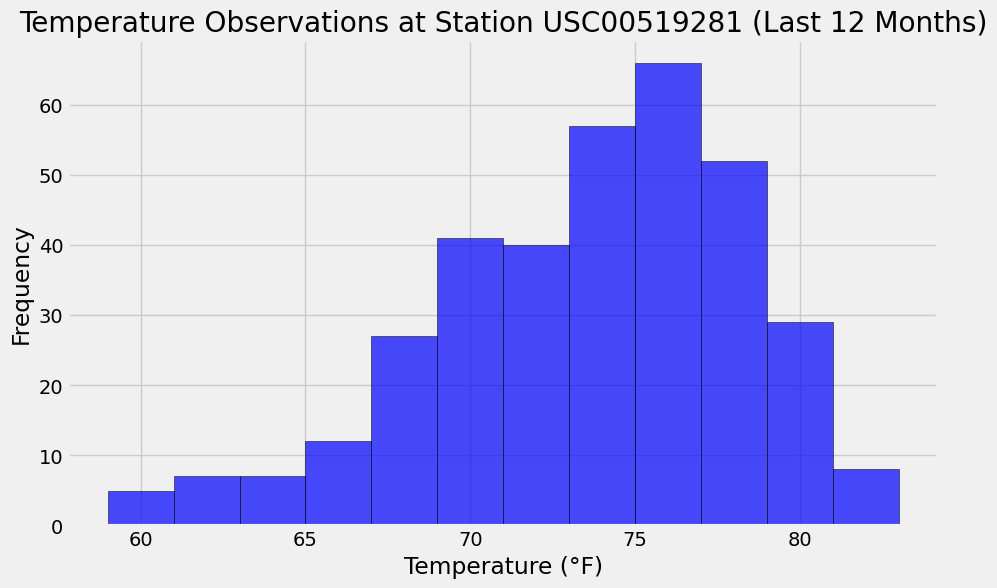

In [107]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

# Convert query results to a Pandas DataFrame
temp_df = pd.DataFrame(temp_data, columns=["date", "temperature"])

# Plot the histogram
plt.figure(figsize=(10,6))
plt.hist(temp_df["temperature"], bins=12, alpha=0.7, color="blue", edgecolor="black")

# Formatting the histogram
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency")
plt.title(f"Temperature Observations at Station {most_active_station} (Last 12 Months)")
plt.grid(True)

# Add text annotation


# Show the plot
plt.show()

# Close Session

In [108]:
# Close Session
session.close()